In [1]:
#!/usr/bin/env python
# coding: utf-8

import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import json
import time

import seisbench.models as sbm
import seisbench.data as sbd
import seisbench.generate as sbg

from seisbench.util import worker_seeding
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from scipy.signal import find_peaks



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
print("✓ All imports successful!")

✓ All imports successful!


In [4]:
# Load configuration from JSON file
try:
    with open('config.json', 'r') as f:
        config = json.load(f)
    print("✓ Configuration loaded successfully!")
except FileNotFoundError:
    print("✗ Error: config.json file not found!")
    raise
except json.JSONDecodeError as e:
    print(f"✗ Error: Invalid JSON in config.json: {e}")
    raise
except Exception as e:
    print(f"✗ Unexpected error loading config: {e}")
    raise

✓ Configuration loaded successfully!


In [5]:
config

{'peak_detection': {'sampling_rate': 100, 'height': 0.5, 'distance': 100},
 'training': {'batch_size': 64,
  'num_workers': 4,
  'learning_rate': 0.01,
  'epochs': 50,
  'patience': 5,
  'loss_weights': [0.01, 0.4, 0.59],
  'optimization': {'mixed_precision': True,
   'gradient_accumulation_steps': 1,
   'pin_memory': True,
   'prefetch_factor': 2,
   'persistent_workers': True}},
 'device': {'use_cuda': True, 'device_id': 0}}

In [6]:
# Set random seed for reproducibility
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [7]:
import os

# Loader the picker
try:
    #model = sbm.EQTransformer.from_pretrained("original")
    model = sbm.PhaseNet.from_pretrained("stead")
    print("✓ Model loaded successfully!")
except Exception as e:
    print(f"✗ Error loading model: {e}")
    raise

✓ Model loaded successfully!


In [8]:
# Set up device
device = torch.device(f"cuda:{config['device']['device_id']}" if torch.cuda.is_available() and config['device']['use_cuda'] else "cpu")
print(f"Using device: {device}")
model.to(device)


Using device: cpu


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [9]:
# Print PhaseNet model information
phasenet_total_params = sum(p.numel() for p in model.parameters())
phasenet_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("PhaseNet information:")
print(f"Total parameters: {phasenet_total_params:,}")
print(f"Trainable parameters: {phasenet_trainable_params:,}")
print(f"Model size: {phasenet_total_params * 4 / (1024**2):.2f} MB (float32)")

PhaseNet information:
Total parameters: 268,443
Trainable parameters: 268,443
Model size: 1.02 MB (float32)


In [11]:
# Test XiaoNet forward pass with 600 input
import importlib
import sys
import os

# Add project root to path (notebook is in archive/, go up one level)
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in dir() else os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Remove old module from cache if it exists
if 'models.xn_xiao_net_v2' in sys.modules:
    del sys.modules['models.xn_xiao_net_v2']

# Re-import with fresh code
from models.xn_xiao_net_v2 import XiaoNet

# Create XiaoNet model with 600 sample window
xiao_net = XiaoNet(
    window_len=600,       # 6 seconds @ 100 Hz
    in_channels=3,        # 3 channels (E, N, Z)
    num_phases=3,         # 3 outputs (P, S, noise)
    base_channels=16       # Base channel width for v2
)
xiao_net.to(device)

# Test with a dummy batch to verify dimensions
test_input = torch.randn(2, 3, 600).to(device)
try:
    test_output = xiao_net(test_input)
    print(f"✓ XiaoNet forward pass successful!")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Output shape: {test_output.shape}")
except Exception as e:
    print(f"✗ Error during forward pass: {e}")
    raise

# Count parameters
total_params = sum(p.numel() for p in xiao_net.parameters())
trainable_params = sum(p.numel() for p in xiao_net.parameters() if p.requires_grad)

print(f"\n✓ XiaoNet v2 loaded!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024**2):.2f} MB (float32)")

✓ XiaoNet forward pass successful!
  Input shape: torch.Size([2, 3, 600])
  Output shape: torch.Size([2, 3, 600])

✓ XiaoNet v2 loaded!
Total parameters: 151,619
Trainable parameters: 151,619
Model size: 0.58 MB (float32)


In [12]:
# Load the data
print("Loading data...")
try:
    data = sbd.OKLA_1Mil_120s_Ver_3(sampling_rate=100, force=True, component_order="ENZ")
    print("✓ Data loaded successfully!")

except Exception as e:

    print(f"✗ Error loading data: {e}")
    raise

Loading data...
✓ Data loaded successfully!


In [13]:
# Create a random sample
sample_fraction = 0.01  # Sample 20% of the data
print(f"Creating random sample of {sample_fraction*100}% of the data...")

Creating random sample of 1.0% of the data...


In [14]:
# Create a random mask for sampling
mask = np.random.random(len(data)) < sample_fraction
data.filter(mask)

print(f"Sampled dataset size: {len(data)}")


Sampled dataset size: 11270


In [15]:
print("Sample metadata:")
data.metadata.head(20)

Sample metadata:


,index,station_network_code,station_code,trace_channel,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_p_arrival_sample,trace_p_status,trace_p_weight,...,trace_snr_db,trace_coda_end_sample,trace_start_time,trace_category,trace_name,split,trace_name_original,trace_chunk,trace_sampling_rate_hz,trace_component_order
99,99,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2023-09-24T13:16:05.274999Z,earthquake_local,"bucket0$75,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2023-09-24T1316052023-09-2...,,100,ZNE
524,524,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-03-15T18:13:14.055000Z,earthquake_local,"bucket0$377,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-03-15T1813142024-03-1...,,100,ZNE
540,540,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-03-22T08:27:12.879999Z,earthquake_local,"bucket0$391,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-03-22T0827122024-03-2...,,100,ZNE
742,742,2V,TG11,EHE,35.2689,-97.8146,407.0,6000.0,manual,1.0,...,NaN,NaN,2024-07-12T12:18:13.550000Z,earthquake_local,"bucket4$82,:3,:12001",dev,2V.TG11.EHE.EHN.EHZ.2024-07-12T1218132024-07-1...,,100,ZNE
757,757,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-07-18T08:17:44.720000Z,earthquake_local,"bucket0$549,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-07-18T0817442024-07-1...,,100,ZNE
821,821,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-08-03T03:22:28.699999Z,earthquake_local,"bucket0$593,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-08-03T0322282024-08-0...,,100,ZNE
852,852,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-08-09T10:14:19.479999Z,earthquake_local,"bucket0$611,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-08-09T1014192024-08-0...,,100,ZNE
1062,1062,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-11-19T21:40:44.520000Z,earthquake_local,"bucket5$173,:3,:12001",test,2V.TG11.EHE.EHN.EHZ.2024-11-19T2140442024-11-1...,,100,ZNE
1070,1070,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-12-07T04:18:22.749999Z,earthquake_local,"bucket0$759,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-12-07T0418222024-12-0...,,100,ZNE
1130,1130,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2025-02-19T22:35:23.879999Z,earthquake_local,"bucket0$798,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2025-02-19T2235232025-02-1...,,100,ZNE


In [16]:
# Split data
train, dev, test = data.train_dev_test()

In [17]:

print("Train:", train)
print("Dev:", dev)
print("Test:", test)


Train: OKLA_1Mil_120s_Ver_3 - 7884 traces
Dev: OKLA_1Mil_120s_Ver_3 - 1657 traces
Test: OKLA_1Mil_120s_Ver_3 - 1729 traces


In [18]:
# Set up data augmentation

phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

In [19]:
# Create the data generators for training and validation
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

In [21]:
# Define phase lists for labeling
p_phases = [key for key, val in phase_dict.items() if val == "P"]
s_phases = [key for key, val in phase_dict.items() if val == "S"]

train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    #sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=600, windowlen=1200, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=600, strategy="pad"),
    #sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(sigma=30, dim=0),
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)


In [22]:
# Parameters for peak detection
sampling_rate = config['peak_detection']['sampling_rate']
height = config['peak_detection']['height']
distance = config['peak_detection']['distance']

batch_size = config['training']['batch_size']
num_workers = config['training']['num_workers']

In [23]:
print("=" * 60)
print("TRAINING CONFIGURATION SANITY CHECK")
print("=" * 60)

print("\n📊 Dataset Information:")
print(f"  Total dataset size: {len(data):,} samples")
print(f"  Training set: {len(train):,} samples")
print(f"  Validation set: {len(dev):,} samples")
print(f"  Test set: {len(test):,} samples")
print(f"  Sample fraction used: {sample_fraction*100}%")

print("\n🔧 Data Augmentation Pipeline:")
for i, aug in enumerate(augmentations, 1):
    print(f"  {i}. {aug.__class__.__name__}")
    if hasattr(aug, '__dict__'):
        relevant_attrs = {k: v for k, v in aug.__dict__.items() if not k.startswith('_')}
        for key, val in relevant_attrs.items():
            print(f"     - {key}: {val}")

print("\n🎯 Model Information:")
print(f"  Model type: {model.__class__.__name__}")
print(f"  Device: {device}")

print("\n⚙️ Training Hyperparameters:")
print(f"  Batch size: {batch_size}")
print(f"  Number of workers: {num_workers}")
print(f"  Learning rate: {config['training']['learning_rate']}")
print(f"  Number of epochs: {config['training']['epochs']}")
print(f"  Patience (early stopping): {config['training']['patience']}")

print("\n📈 Peak Detection Parameters:")
print(f"  Sampling rate: {sampling_rate} Hz")
print(f"  Height threshold: {height}")
print(f"  Distance: {distance} samples")

print("\n🔬 Phase Dictionary:")
print(f"  P-phases: {len(p_phases)} types")
print(f"  S-phases: {len(s_phases)} types")

print("\n💾 Data Loader Configuration:")
print(f"  Pin memory: True")
print(f"  Prefetch factor: 4")
print(f"  Persistent workers: True")

print("\n" + "=" * 60)
print("Ready to start training!")
print("=" * 60)

TRAINING CONFIGURATION SANITY CHECK

📊 Dataset Information:
  Total dataset size: 11,270 samples
  Training set: 7,884 samples
  Validation set: 1,657 samples
  Test set: 1,729 samples
  Sample fraction used: 1.0%

🔧 Data Augmentation Pipeline:
  1. WindowAroundSample
     - metadata_keys: ['trace_p_arrival_sample', 'trace_pP_arrival_sample', 'trace_P_arrival_sample', 'trace_P1_arrival_sample', 'trace_Pg_arrival_sample', 'trace_Pn_arrival_sample', 'trace_PmP_arrival_sample', 'trace_pwP_arrival_sample', 'trace_pwPm_arrival_sample', 'trace_s_arrival_sample', 'trace_S_arrival_sample', 'trace_S1_arrival_sample', 'trace_Sg_arrival_sample', 'trace_SmS_arrival_sample', 'trace_Sn_arrival_sample']
     - samples_before: 600
     - selection: random
     - p0: None
     - windowlen: 1200
     - strategy: variable
     - axis: -1
     - key: ('X', 'X')
  2. RandomWindow
     - p0: None
     - windowlen: 600
     - strategy: pad
     - axis: -1
     - key: ('X', 'X')
     - low: None
     - high: 

In [24]:
# Load the data for machine learning

train_loader = DataLoader(train_generator,batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)
val_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)


In [25]:
# Define loss function
def loss_fn(y_pred, y_true, eps=1e-5):
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)
    h = h.mean()
    return -h

In [26]:
def distillation_loss_fn(student_pred, teacher_pred, y_true, temperature=3.0, alpha=0.5, eps=1e-8):
    """
    Combined loss for knowledge distillation.
    Works with softmax outputs by converting back to logits.
    
    Args:
        student_pred: Student model predictions (after softmax) (B, C, L)
        teacher_pred: Teacher model predictions (after softmax) (B, C, L)
        y_true: Ground truth labels (B, C, L)
        temperature: Temperature for softening probability distributions
        alpha: Weight between distillation loss and task loss (0-1)
        eps: Small epsilon for numerical stability
    Returns:
        Combined distillation loss
    """
    
    # Handle shape mismatch if needed
    if student_pred.shape[-1] != teacher_pred.shape[-1]:
        teacher_pred = F.interpolate(
            teacher_pred, 
            size=student_pred.shape[-1],
            mode='linear',
            align_corners=True
        )
        if y_true.shape[-1] != student_pred.shape[-1]:
            y_true = F.interpolate(
                y_true,
                size=student_pred.shape[-1],
                mode='linear',
                align_corners=True
            )
            y_true = y_true / (y_true.sum(dim=1, keepdim=True) + eps)
    
    # Task loss: student vs ground truth (standard cross-entropy)
    task_loss = -(y_true * torch.log(student_pred + eps)).mean(-1).sum(-1).mean()
    
    # Convert probabilities back to logits (inverse of softmax)
    # log(softmax(z)) = z - log(sum(exp(z))) = log_unnormalized
    student_logits = torch.log(student_pred + eps)
    teacher_logits = torch.log(teacher_pred + eps)
    
    # Now apply temperature scaling CORRECTLY on the recovered logits
    student_soft = F.log_softmax(student_logits / temperature, dim=1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
    
    # KL divergence between soft distributions
    distill_loss = F.kl_div(student_soft, teacher_soft, reduction='batchmean')
    
    # Scale distillation loss by T^2 (standard practice)
    distill_loss = distill_loss * (temperature ** 2)
    
    # Combine losses
    total_loss = alpha * distill_loss + (1 - alpha) * task_loss
    
    return total_loss

print("✓ Knowledge distillation loss function defined!")
print(f"  - Works with softmax outputs (seisbench compatible)")
print(f"  - Converts probabilities back to logits internally")
print(f"  - Applies proper temperature scaling")

✓ Knowledge distillation loss function defined!
  - Works with softmax outputs (seisbench compatible)
  - Converts probabilities back to logits internally
  - Applies proper temperature scaling


In [ ]:
# Knowledge Distillation Loss Function
def distillation_loss_fn(student_pred, teacher_pred, y_true, temperature=3.0, alpha=0.5, eps=1e-5):
    """
    Combined loss for knowledge distillation.
    
    Args:
        student_pred: Student model predictions (after softmax)
        teacher_pred: Teacher model predictions (after softmax)
        y_true: Ground truth labels
        temperature: Temperature for softening probability distributions (higher = softer)
        alpha: Weight between distillation loss and task loss (0-1)
               alpha=1.0: only learn from teacher
               alpha=0.0: only learn from ground truth
        eps: Small epsilon for numerical stability
    
    Returns:
        Combined distillation loss
    """
    # Task loss: student vs ground truth (standard cross-entropy)
    task_loss = -(y_true * torch.log(student_pred + eps)).mean(-1).sum(-1).mean()
    
    # Distillation loss: student vs teacher (KL divergence with temperature scaling)
    # Apply temperature scaling to soften the distributions
    student_log_soft = torch.log((student_pred ** (1.0/temperature)) + eps)
    teacher_soft = teacher_pred ** (1.0/temperature)
    
    # Normalize after temperature scaling
    student_log_soft = student_log_soft - torch.logsumexp(student_log_soft, dim=1, keepdim=True)
    teacher_soft = teacher_soft / teacher_soft.sum(dim=1, keepdim=True)
    
    # KL divergence
    distill_loss = -(teacher_soft * student_log_soft).mean(-1).sum(-1).mean()
    
    # Scale distillation loss by T^2 (common practice in knowledge distillation)
    distill_loss = distill_loss * (temperature ** 2)
    
    # Combine losses
    total_loss = alpha * distill_loss + (1 - alpha) * task_loss
    
    return total_loss

print("✓ Knowledge distillation loss function defined!")
print(f"  - Temperature: Controls softness of probability distributions")
print(f"  - Alpha: Balances learning from teacher vs ground truth")

In [27]:
# Configure Teacher and Student Models for Knowledge Distillation
print("=" * 60)
print("KNOWLEDGE DISTILLATION SETUP")
print("=" * 60)

# Teacher model: PhaseNet (pretrained, frozen)
teacher_model = model  # PhaseNet loaded earlier
teacher_model.eval()   # Set to evaluation mode

# Freeze all teacher parameters - no training
for param in teacher_model.parameters():
    param.requires_grad = False

teacher_params = sum(p.numel() for p in teacher_model.parameters())
teacher_trainable = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)

print("\n👨‍🏫 Teacher Model (PhaseNet):")
print(f"  Total parameters: {teacher_params:,}")
print(f"  Trainable parameters: {teacher_trainable:,} (frozen ✓)")
print(f"  Model size: {teacher_params * 4 / (1024**2):.2f} MB")

# Student model: XiaoNet (will be trained)
student_model = xiao_net  # XiaoNet created earlier
student_model.train()      # Set to training mode

student_params = sum(p.numel() for p in student_model.parameters())
student_trainable = sum(p.numel() for p in student_model.parameters() if p.requires_grad)

print("\n👨‍🎓 Student Model (XiaoNet):")
print(f"  Total parameters: {student_params:,}")
print(f"  Trainable parameters: {student_trainable:,}")
print(f"  Model size: {student_params * 4 / (1024**2):.2f} MB")

print("\n📊 Model Comparison:")
print(f"  Parameter reduction: {(1 - student_params/teacher_params)*100:.1f}%")
print(f"  Size reduction: {(1 - (student_params * 4 / (1024**2)) / (teacher_params * 4 / (1024**2)))*100:.1f}%")

print("\n" + "=" * 60)
print("✓ Teacher-Student configuration complete!")
print("=" * 60)

KNOWLEDGE DISTILLATION SETUP

👨‍🏫 Teacher Model (PhaseNet):
  Total parameters: 268,443
  Trainable parameters: 0 (frozen ✓)
  Model size: 1.02 MB

👨‍🎓 Student Model (XiaoNet):
  Total parameters: 151,619
  Trainable parameters: 151,619
  Model size: 0.58 MB

📊 Model Comparison:
  Parameter reduction: 43.5%
  Size reduction: 43.5%

✓ Teacher-Student configuration complete!


In [28]:
# Learning rate and number of epochs
learning_rate = config['training']['learning_rate']
epochs = config['training']['epochs']

In [29]:
# Setup optimizer for STUDENT model only (teacher is frozen)
optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)

print(f"✓ Optimizer configured for student model")
print(f"  Learning rate: {learning_rate}")
print(f"  Optimizing {student_trainable:,} parameters")


✓ Optimizer configured for student model
  Learning rate: 0.01
  Optimizing 151,619 parameters


In [30]:
# Training function with knowledge distillation
def train_one_epoch_distillation(dataloader, student_model, teacher_model, optimizer, device, 
                                   temperature=2.0, alpha=0.7):
    """
    Train student model for one epoch using knowledge distillation.
    
    Args:
        dataloader: Training data loader
        student_model: Student model to train
        teacher_model: Teacher model (frozen)
        optimizer: Optimizer for student model
        device: Device to train on
        temperature: Temperature for distillation
        alpha: Weight between distillation and task loss
    """
    student_model.train()
    teacher_model.eval()  # Teacher always in eval mode
    
    total_loss = 0
    task_loss_total = 0
    distill_loss_total = 0  # You calculate this but never use it - see below
    size = len(dataloader.dataset)
    
    for batch_id, batch in enumerate(dataloader):
        X = batch["X"].to(device)
        y_true = batch["y"].to(device)
        
        # Get predictions from both models
        student_pred = student_model(X)
        
        with torch.no_grad():  # No gradients for teacher
            teacher_pred = teacher_model(X)
        
        # Calculate combined loss
        loss = distillation_loss_fn(student_pred, teacher_pred, y_true, 
                                     temperature=temperature, alpha=alpha)
        
        # CHANGE 1: Calculate individual losses for monitoring
        # Match the eps value with your distillation_loss_fn
        eps = 1e-8  # Changed from 1e-5 to match loss function
        
        with torch.no_grad():  # Don't need gradients for monitoring
            task_loss = -(y_true * torch.log(student_pred.clamp(min=eps) + eps)).mean(-1).sum(-1).mean()
            
            # CHANGE 2: Actually calculate distillation loss for monitoring
            student_logits = torch.log(student_pred.clamp(min=eps, max=1.0-eps))
            teacher_logits = torch.log(teacher_pred.clamp(min=eps, max=1.0-eps))
            student_soft = F.log_softmax(student_logits / temperature, dim=1)
            teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
            distill_loss = F.kl_div(student_soft, teacher_soft, reduction='batchmean') * (temperature ** 2)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # CHANGE 3: Print more informative loss breakdown
        if batch_id % 5 == 0:
            current = batch_id * len(batch['X'])
            print(f"loss: {loss.item():>7f} [task: {task_loss.item():>6f}, distill: {distill_loss.item():>6f}] [{current:>5d}/{size:>5d}]")
        
        total_loss += loss.item()
        task_loss_total += task_loss.item()
        distill_loss_total += distill_loss.item()  # Now actually used
    
    avg_loss = total_loss / len(dataloader)
    avg_task_loss = task_loss_total / len(dataloader)
    avg_distill_loss = distill_loss_total / len(dataloader)  # CHANGE 4: Return this too
    
    return avg_loss, avg_task_loss, avg_distill_loss  # CHANGE 5: Return 3 values


# Evaluation function for student model
def evaluate_student_model(dataloader, student_model, device):
    """
    Evaluate student model on validation/test set.
    Uses standard cross-entropy loss (no teacher involved).
    """
    student_model.eval()
    val_loss = 0
    eps = 1e-8  # CHANGE 6: Match eps with training
    
    with torch.no_grad():
        for batch in dataloader:
            X = batch["X"].to(device)
            y_true = batch["y"].to(device)
            
            student_pred = student_model(X)
            # CHANGE 7: Add clamp for numerical stability
            loss = -(y_true * torch.log(student_pred.clamp(min=eps) + eps)).mean(-1).sum(-1).mean()
            val_loss += loss.item()
    
    return val_loss / len(dataloader)

print("✓ Distillation training functions defined!")
print("  - train_one_epoch_distillation: Trains student with teacher guidance")
print("  - evaluate_student_model: Evaluates student independently")

✓ Distillation training functions defined!
  - train_one_epoch_distillation: Trains student with teacher guidance
  - evaluate_student_model: Evaluates student independently


In [ ]:
# Training function with knowledge distillation
def train_one_epoch_distillation(dataloader, student_model, teacher_model, optimizer, device, 
                                   temperature=3.0, alpha=0.5):
    """
    Train student model for one epoch using knowledge distillation.
    
    Args:
        dataloader: Training data loader
        student_model: Student model to train
        teacher_model: Teacher model (frozen)
        optimizer: Optimizer for student model
        device: Device to train on
        temperature: Temperature for distillation
        alpha: Weight between distillation and task loss
    """
    student_model.train()
    teacher_model.eval()  # Teacher always in eval mode
    
    total_loss = 0
    task_loss_total = 0
    distill_loss_total = 0
    size = len(dataloader.dataset)

    for batch_id, batch in enumerate(dataloader):
        X = batch["X"].to(device)
        y_true = batch["y"].to(device)
        
        # Get predictions from both models
        student_pred = student_model(X)
        
        with torch.no_grad():  # No gradients for teacher
            teacher_pred = teacher_model(X)
        
        # Calculate combined loss
        loss = distillation_loss_fn(student_pred, teacher_pred, y_true, 
                                     temperature=temperature, alpha=alpha)
        
        # Also calculate individual losses for monitoring
        eps = 1e-5
        task_loss = -(y_true * torch.log(student_pred + eps)).mean(-1).sum(-1).mean()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            print(f"loss: {loss.item():>7f}  [{batch_id * len(batch['X']):>5d}/{size:>5d}]")

        total_loss += loss.item()
        task_loss_total += task_loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_task_loss = task_loss_total / len(dataloader)
    
    return avg_loss, avg_task_loss


# Evaluation function for student model
def evaluate_student_model(dataloader, student_model, device):
    """
    Evaluate student model on validation/test set.
    Uses standard cross-entropy loss (no teacher involved).
    """
    student_model.eval()
    val_loss = 0
    eps = 1e-5

    with torch.no_grad():
        for batch in dataloader:
            X = batch["X"].to(device)
            y_true = batch["y"].to(device)
            
            student_pred = student_model(X)
            loss = -(y_true * torch.log(student_pred + eps)).mean(-1).sum(-1).mean()
            val_loss += loss.item()

    return val_loss / len(dataloader)


print("✓ Distillation training functions defined!")
print("  - train_one_epoch_distillation: Trains student with teacher guidance")
print("  - evaluate_student_model: Evaluates student independently")

In [31]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, 
                 best_model_path='best_student_model.pth'):
        """
        Args:
            patience: How many epochs to wait after last improvement
            verbose: If True, prints messages
            delta: Minimum change to qualify as an improvement
            best_model_path: Path to save the best model
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.best_model_path = best_model_path
        self.best_epoch = 0
    
    def __call__(self, val_loss, model, epoch, optimizer=None):
        """
        Args:
            val_loss: Current validation loss
            model: Model to potentially save
            epoch: Current epoch number
            optimizer: (Optional) Optimizer to save state
        """
        score = -val_loss
        
        if self.best_score is None:
            # First epoch
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch, optimizer)
        elif score < self.best_score + self.delta:
            # No improvement
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'Early stopping triggered! Best model was at epoch {self.best_epoch}')
        else:
            # Improvement found
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch, optimizer)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model, epoch, optimizer=None):
        """Save model when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        
        # Save model state
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
        }
        
        # Optionally save optimizer state for resuming training
        if optimizer is not None:
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        
        torch.save(checkpoint, self.best_model_path)
        self.val_loss_min = val_loss
        self.best_epoch = epoch
    
    def load_best_model(self, model, optimizer=None):
        """Load the best saved model."""
        checkpoint = torch.load(self.best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        if optimizer is not None and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        if self.verbose:
            print(f'Loaded best model from epoch {checkpoint["epoch"]} with val_loss={checkpoint["val_loss"]:.6f}')
        
        return checkpoint['epoch'], checkpoint['val_loss']

print("✓ Improved EarlyStopping class defined!")
print("  - Saves best model only (no redundant saves)")
print("  - Tracks best epoch")
print("  - Can save/load optimizer state")
print("  - No unnecessary 'final_model' (best model is what you want)")

✓ Improved EarlyStopping class defined!
  - Saves best model only (no redundant saves)
  - Tracks best epoch
  - Can save/load optimizer state
  - No unnecessary 'final_model' (best model is what you want)


In [ ]:
# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, checkpoint_path='checkpoint.pt', 
                 best_model_path='best_model.pth', final_model_path='final_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.best_model_path = best_model_path
        self.final_model_path = final_model_path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.save_best_model(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                self.save_final_model(model)
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.save_best_model(model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.checkpoint_path)
        self.val_loss_min = val_loss

    def save_best_model(self, model):
        if self.verbose:
            print(f'Saving best model to {self.best_model_path}')
        torch.save(model.state_dict(), self.best_model_path)

    def save_final_model(self, model):
        if self.verbose:
            print(f'Early stopping triggered. Saving final model to {self.final_model_path}')
        torch.save(model.state_dict(), self.final_model_path)


In [ ]:
# Function to train for one epoch
def train_one_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    size = len(dataloader.dataset)

    for batch_id, batch in enumerate(dataloader):
        pred = model(batch["X"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            print(f"loss: {loss.item():>7f}  [{batch_id * len(batch['X']):>5d}/{size:>5d}]")

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
# Function to evaluate the model
def evaluate_model(dataloader, model, loss_fn, device):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(device))
            val_loss += loss_fn(pred, batch["y"].to(device)).item()

    return val_loss / len(dataloader)


In [ ]:
# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.fill_between(range(len(history['train_loss'])), 
                     history['train_loss'], history['val_loss'],
                     alpha=0.3, color='red', 
                     where=(np.array(history['val_loss']) > np.array(history['train_loss'])),
                     label='Potential Overfitting Gap')
    plt.savefig('training_history.png')
    plt.close()


In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history, save_path='training_history.png'):
    """
    Plots multiple metrics from training history for knowledge distillation.
    
    Args:
        history: Dictionary with keys:
            - 'train_loss': Total training loss (required)
            - 'train_task_loss': Task loss component (optional)
            - 'train_distill_loss': Distillation loss component (optional)
            - 'val_loss': Validation loss (required)
            - 'p_f1', 's_f1', 'noise_f1': Per-class F1 scores (optional)
        save_path: Where to save the figure
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Determine subplot layout based on available data
    # FIXED: Check if lists are non-empty, not just if keys exist
    has_component_losses = ('train_task_loss' in history and len(history['train_task_loss']) > 0 and 
                           'train_distill_loss' in history and len(history['train_distill_loss']) > 0)
    has_f1_scores = any(k in history and len(history[k]) > 0 for k in ['p_f1', 's_f1', 'noise_f1'])
    
    if has_component_losses and has_f1_scores:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        ax1, ax2, ax3, ax4 = axes.flatten()
    elif has_component_losses or has_f1_scores:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        ax1, ax2 = axes
        ax3 = ax4 = None
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
        ax2 = ax3 = ax4 = None
    
    # === Plot 1: Overall Loss ===
    ax1.plot(epochs, history['train_loss'], label='Train Total Loss', 
             color='blue', linewidth=2, marker='o', markersize=3)
    ax1.plot(epochs, history['val_loss'], label='Validation Loss', 
             color='red', linewidth=2, marker='s', markersize=3)
    
    # Highlight overfitting
    train_arr = np.array(history['train_loss'])
    val_arr = np.array(history['val_loss'])
    ax1.fill_between(epochs, train_arr, val_arr,
                     alpha=0.2, color='red',
                     where=(val_arr > train_arr),
                     label='Overfitting Region')
    
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Overall Training Progress', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # Mark best validation loss
    best_epoch = np.argmin(val_arr) + 1
    best_val = val_arr[best_epoch - 1]
    ax1.axvline(x=best_epoch, color='green', linestyle=':', alpha=0.7, label=f'Best Val (Epoch {best_epoch})')
    ax1.plot(best_epoch, best_val, 'g*', markersize=15)
    ax1.legend(loc='best')
    
    # === Plot 2: Component Losses ===
    if has_component_losses and ax2 is not None:
        ax2.plot(epochs, history['train_task_loss'], label='Task Loss (Ground Truth)', 
                 color='green', linewidth=2, marker='o', markersize=3)
        ax2.plot(epochs, history['train_distill_loss'], label='Distillation Loss (Teacher)', 
                 color='orange', linewidth=2, marker='s', markersize=3)
        
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
        ax2.set_title('Loss Components (Task vs Distillation)', fontsize=14, fontweight='bold')
        ax2.legend(loc='best')
        ax2.grid(True, linestyle='--', alpha=0.3)
        
        # Add text showing latest losses
        last_task = history['train_task_loss'][-1]
        last_distill = history['train_distill_loss'][-1]
        ax2.text(0.05, 0.95, f'Latest losses:\nTask: {last_task:.4f}\nDistill: {last_distill:.4f}', 
                transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # === Plot 3: Per-Class F1 Scores ===
    # FIXED: Only plot if data exists and is non-empty
    if has_f1_scores and ax3 is not None:
        if 'p_f1' in history and len(history['p_f1']) > 0:
            ax3.plot(epochs, history['p_f1'], label='P-wave F1', 
                    color='blue', linewidth=2, marker='o', markersize=3)
        if 's_f1' in history and len(history['s_f1']) > 0:
            ax3.plot(epochs, history['s_f1'], label='S-wave F1', 
                    color='red', linewidth=2, marker='s', markersize=3)
        if 'noise_f1' in history and len(history['noise_f1']) > 0:
            ax3.plot(epochs, history['noise_f1'], label='Noise F1', 
                    color='gray', linewidth=2, marker='^', markersize=3)
        
        ax3.set_xlabel('Epoch', fontsize=12)
        ax3.set_ylabel('F1 Score', fontsize=12)
        ax3.set_title('Per-Class F1 Scores', fontsize=14, fontweight='bold')
        ax3.legend(loc='best')
        ax3.grid(True, linestyle='--', alpha=0.3)
        ax3.set_ylim([0, 1.05])
        
        # Add horizontal line at 0.8 (typical good performance threshold)
        ax3.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Target (0.8)')
        ax3.legend(loc='best')
    
    # === Plot 4: Loss Gap Analysis ===
    if has_component_losses and ax4 is not None:
        # Plot the gap between train and val loss
        gap = val_arr - train_arr
        ax4.plot(epochs, gap, label='Val - Train Loss Gap', 
                color='purple', linewidth=2, marker='o', markersize=3)
        ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax4.fill_between(epochs, 0, gap, 
                        alpha=0.3, color='purple',
                        where=(gap > 0))
        
        ax4.set_xlabel('Epoch', fontsize=12)
        ax4.set_ylabel('Loss Gap', fontsize=12)
        ax4.set_title('Generalization Gap (Val - Train)', fontsize=14, fontweight='bold')
        ax4.legend(loc='best')
        ax4.grid(True, linestyle='--', alpha=0.3)
        
        # Add text indicating overfitting degree
        avg_gap = np.mean(gap[len(gap)//2:])  # Average gap in second half of training
        status = 'Good' if avg_gap < 0.01 else 'Moderate' if avg_gap < 0.05 else 'High'
        color = 'green' if status == 'Good' else 'orange' if status == 'Moderate' else 'red'
        ax4.text(0.05, 0.95, f'Overfitting: {status}\nAvg Gap: {avg_gap:.4f}', 
                transform=ax4.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Training history plot saved to {save_path}")
    plt.close()

    # Print summary statistics
    print("\n" + "="*50)
    print("TRAINING SUMMARY")
    print("="*50)
    print(f"Best Validation Loss: {best_val:.6f} at Epoch {best_epoch}")
    print(f"Final Train Loss: {history['train_loss'][-1]:.6f}")
    print(f"Final Val Loss: {history['val_loss'][-1]:.6f}")
    
    if has_f1_scores:
        print("\nFinal F1 Scores:")
        if 'p_f1' in history and len(history['p_f1']) > 0:
            print(f"  P-wave: {history['p_f1'][-1]:.4f}")
        if 's_f1' in history and len(history['s_f1']) > 0:
            print(f"  S-wave: {history['s_f1'][-1]:.4f}")
        if 'noise_f1' in history and len(history['noise_f1']) > 0:
            print(f"  Noise:  {history['noise_f1'][-1]:.4f}")
    print("="*50 + "\n")


# Helper function to initialize history dictionary
def init_history():
    """Initialize training history dictionary."""
    return {
        'train_loss': [],
        'train_task_loss': [],
        'train_distill_loss': [],
        'val_loss': [],
        'p_f1': [],
        's_f1': [],
        'noise_f1': []
    }

print("✓ Fixed plotting functions defined!")
print("  - Now checks if F1 lists are non-empty before plotting")
print("  - Multi-panel layout with loss components")
print("  - Highlights best epoch and overfitting regions")

✓ Fixed plotting functions defined!
  - Now checks if F1 lists are non-empty before plotting
  - Multi-panel layout with loss components
  - Highlights best epoch and overfitting regions


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Plots multiple metrics from training history.
    Supports:
        - Training total loss
        - Training task loss
        - Training distillation loss
        - Validation loss
        - Optional per-class F1 (P, S, Noise)
    """
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 7))

    # 1. Total training loss
    plt.plot(epochs, history['train_loss'], label='Train Total Loss', color='blue')
    
    # 2. Training task loss (if present)
    if 'train_task_loss' in history:
        plt.plot(epochs, history['train_task_loss'], label='Train Task Loss', color='green', linestyle='--')
    
    # 3. Training distillation loss (if present)
    if 'train_distill_loss' in history:
        plt.plot(epochs, history['train_distill_loss'], label='Train Distill Loss', color='orange', linestyle='--')
    
    # 4. Validation loss
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='red')
    
    # 5. Optional per-class F1
    for cls in ['p_f1', 's_f1', 'noise_f1']:
        if cls in history:
            plt.plot(epochs, history[cls], label=f'Val {cls.upper()}', linestyle=':')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss / F1')
    plt.title('Training History with Distillation')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Highlight overfitting if possible
    if 'train_loss' in history and 'val_loss' in history:
        train_arr = np.array(history['train_loss'])
        val_arr = np.array(history['val_loss'])
        plt.fill_between(epochs, train_arr, val_arr,
                         alpha=0.2, color='red',
                         where=(val_arr > train_arr),
                         label='Potential Overfitting')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()


In [33]:
# Training routine with EarlyStopping and scheduler for Knowledge Distillation
def train_model_distillation(train_loader, val_loader, student_model, teacher_model, 
                              optimizer, device, num_epochs=25, patience=7, 
                              temperature=3.0, alpha=0.5, 
                              best_model_path='best_student_distilled.pth',
                              plot_path='student_distillation_history.png'):
    """
    Train student model using knowledge distillation with EarlyStopping and scheduler.
    
    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        student_model: Student model to train
        teacher_model: Teacher model (frozen)
        optimizer: Optimizer for student model
        device: Device to train on
        num_epochs: Maximum number of epochs
        patience: EarlyStopping patience
        temperature: Temperature for softening probability distributions (try 2.0-3.0)
        alpha: Weight between distillation and task loss (0-1, try 0.7)
        best_model_path: Path to save best model
        plot_path: Path to save training history plot
    
    Returns:
        student_model: Trained student model (with best weights loaded)
        history: Training history dictionary
    """
    # Initialize early stopping with updated class
    early_stopping = EarlyStopping(
        patience=patience, 
        verbose=True,
        delta=0.0001,  # Minimum improvement threshold
        best_model_path=best_model_path
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=3, 
        verbose=True,
        min_lr=1e-7  # Don't let LR go too low
    )
    
    # Initialize history tracking
    history = init_history()
    
    # Freeze teacher model
    teacher_model.eval()
    for param in teacher_model.parameters():
        param.requires_grad = False
    
    print("\n" + "=" * 70)
    print("STARTING KNOWLEDGE DISTILLATION TRAINING")
    print("=" * 70)
    print(f"Configuration:")
    print(f"  Temperature: {temperature}")
    print(f"  Alpha (distillation weight): {alpha}")
    print(f"  Max Epochs: {num_epochs}")
    print(f"  Patience: {patience}")
    print(f"  Initial LR: {optimizer.param_groups[0]['lr']:.2e}")
    print("=" * 70)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 70)
        
        # Training phase with distillation
        train_loss, task_loss, distill_loss = train_one_epoch_distillation(
            train_loader, student_model, teacher_model, optimizer, device, 
            temperature=temperature, alpha=alpha
        )
        
        # Validation phase (student only, no teacher)
        val_loss = evaluate_student_model(val_loader, student_model, device)
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_task_loss'].append(task_loss)
        history['train_distill_loss'].append(distill_loss)
        history['val_loss'].append(val_loss)
        
        # Optional: Calculate and record F1 scores if you have the function
        # f1_scores = calculate_f1_scores(student_model, val_loader, device)
        # history['p_f1'].append(f1_scores['p'])
        # history['s_f1'].append(f1_scores['s'])
        # history['noise_f1'].append(f1_scores['noise'])
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Total Loss:  {train_loss:.6f}")
        print(f"  Train Task Loss:   {task_loss:.6f}")
        print(f"  Train Distill Loss: {distill_loss:.6f}")
        print(f"  Val Loss:          {val_loss:.6f}")
        print(f"  Current LR:        {optimizer.param_groups[0]['lr']:.2e}")
        
        # Step scheduler
        scheduler.step(val_loss)
        
        # Check early stopping (pass optimizer to save its state too)
        early_stopping(val_loss, student_model, epoch, optimizer)
        
        if early_stopping.early_stop:
            print("\n" + "=" * 70)
            print("✓ Early stopping triggered!")
            print(f"✓ Best model was at epoch {early_stopping.best_epoch}")
            print("=" * 70)
            break
    
    # Load best model weights
    print("\nLoading best model...")
    best_epoch, best_val_loss = early_stopping.load_best_model(student_model, optimizer)
    print(f"✓ Loaded best model from epoch {best_epoch} with val_loss={best_val_loss:.6f}")
    
    # Plot training history
    print("\nGenerating training plots...")
    plot_training_history(history, save_path=plot_path)
    
    return student_model, history


if __name__ == "__main__":
    print("\n" + "=" * 70)
    print("KNOWLEDGE DISTILLATION SETUP")
    print("=" * 70)
    
    # Get configuration parameters
    patience = config['training'].get('patience', 10)  # Default to 10 if not specified
    temperature = config['training'].get('temperature', 2.0)  # Lower temp for sharp seismic picks
    alpha = config['training'].get('alpha', 0.7)  # Higher alpha = learn more from teacher
    
    print(f"Training Configuration:")
    print(f"  Epochs: {epochs}")
    print(f"  Patience: {patience}")
    print(f"  Temperature: {temperature}")
    print(f"  Alpha: {alpha}")
    print(f"  Device: {device}")
    print("=" * 70)
    
    # Verify teacher model is loaded and on correct device
    teacher_model.to(device)
    teacher_model.eval()
    print("\n✓ Teacher model loaded and ready")
    print(f"  Teacher parameters: {sum(p.numel() for p in teacher_model.parameters()):,}")
    
    # Verify student model
    student_model.to(device)
    print("✓ Student model loaded and ready")
    print(f"  Student parameters: {sum(p.numel() for p in student_model.parameters()):,}")
    print(f"  Compression ratio: {sum(p.numel() for p in teacher_model.parameters()) / sum(p.numel() for p in student_model.parameters()):.2f}x")
    
    # Run training with knowledge distillation
    try:
        trained_student, training_history = train_model_distillation(
            train_loader=train_loader,
            val_loader=val_loader,
            student_model=student_model,
            teacher_model=teacher_model,
            optimizer=optimizer,
            device=device,
            num_epochs=epochs,
            patience=patience,
            temperature=temperature,
            alpha=alpha,
            best_model_path='best_student_distilled.pth',
            plot_path='student_distillation_history.png'
        )
        
        # Evaluate student on test set
        print("\n" + "=" * 70)
        print("FINAL EVALUATION ON TEST SET")
        print("=" * 70)
        
        test_loss = evaluate_student_model(test_loader, trained_student, device)
        print(f"Test Loss: {test_loss:.6f}")
        
        # Compare with teacher if desired
        print("\nComparing with Teacher Model:")
        teacher_test_loss = evaluate_student_model(test_loader, teacher_model, device)
        print(f"  Teacher Test Loss:  {teacher_test_loss:.6f}")
        print(f"  Student Test Loss:  {test_loss:.6f}")
        print(f"  Performance Gap:    {test_loss - teacher_test_loss:.6f}")
        
        if test_loss < teacher_test_loss * 1.1:  # Within 10% of teacher
            print("  ✓ Student performance is close to teacher!")
        
        # Optional: Calculate and display F1 scores
        # print("\nPer-Class Performance:")
        # f1_scores = calculate_f1_scores(trained_student, test_loader, device)
        # print(f"  P-wave F1:  {f1_scores['p']:.4f}")
        # print(f"  S-wave F1:  {f1_scores['s']:.4f}")
        # print(f"  Noise F1:   {f1_scores['noise']:.4f}")
        
        print("=" * 70)
        print("\n✓ Knowledge Distillation Training Completed Successfully!")
        print(f"✓ Best model saved to: best_student_distilled.pth")
        print(f"✓ Training plot saved to: student_distillation_history.png")
        
    except Exception as e:
        print("\n" + "=" * 70)
        print("ERROR DURING TRAINING")
        print("=" * 70)
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()
        raise


KNOWLEDGE DISTILLATION SETUP
Training Configuration:
  Epochs: 50
  Patience: 5
  Temperature: 2.0
  Alpha: 0.7
  Device: cpu

✓ Teacher model loaded and ready
  Teacher parameters: 268,443
✓ Student model loaded and ready
  Student parameters: 151,619
  Compression ratio: 1.77x

STARTING KNOWLEDGE DISTILLATION TRAINING
Configuration:
  Temperature: 2.0
  Alpha (distillation weight): 0.7
  Max Epochs: 50
  Patience: 5
  Initial LR: 1.00e-02

Epoch 1/50
----------------------------------------------------------------------


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



ERROR DURING TRAINING
Error: Sizes of tensors must match except in dimension 1. Expected size 9 but got size 1 for tensor number 1 in the list.


Traceback (most recent call last):
  File "/var/folders/sd/gqkj0t9n16n8_qtbhd_wlhp80000gq/T/ipykernel_77316/3287422639.py", line 155, in <module>
    trained_student, training_history = train_model_distillation(
                                        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/sd/gqkj0t9n16n8_qtbhd_wlhp80000gq/T/ipykernel_77316/3287422639.py", line 70, in train_model_distillation
    train_loss, task_loss, distill_loss = train_one_epoch_distillation(
                                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/sd/gqkj0t9n16n8_qtbhd_wlhp80000gq/T/ipykernel_77316/501739215.py", line 32, in train_one_epoch_distillation
    teacher_pred = teacher_model(X)
                   ^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ML/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ML/lib/python

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 9 but got size 1 for tensor number 1 in the list.

In [ ]:
# Training routine with EarlyStopping and scheduler for Knowledge Distillation
def train_model_distillation(train_loader, val_loader, student_model, teacher_model, optimizer, device, 
                              num_epochs=25, patience=7, temperature=3.0, alpha=0.5):
    """
    Train student model using knowledge distillation with EarlyStopping and scheduler.
    
    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        student_model: Student model to train
        teacher_model: Teacher model (frozen)
        optimizer: Optimizer for student model
        device: Device to train on
        num_epochs: Maximum number of epochs
        patience: EarlyStopping patience
        temperature: Temperature for softening probability distributions
        alpha: Weight between distillation and task loss
    """
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    history = {
        'train_loss': [],
        'val_loss': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("=" * 60)
        
        # Training phase (distillation)
        train_loss, task_loss = train_one_epoch_distillation(
            train_loader, student_model, teacher_model, optimizer, device, 
            temperature=temperature, alpha=alpha
        )
        
        # Validation phase (student only)
        val_loss = evaluate_student_model(val_loader, student_model, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.6f}")
        print(f"  Train Task Loss: {task_loss:.6f}")
        print(f"  Val Loss: {val_loss:.6f}")

        scheduler.step(val_loss)
        early_stopping(val_loss, student_model)
        if early_stopping.early_stop:
            print("\n" + "=" * 60)
            print("✓ Early stopping triggered!")
            break

    # Load best model
    student_model.load_state_dict(torch.load('checkpoint.pt'))
    plot_training_history(history)
    return student_model, history

if __name__ == "__main__":
    # Call the training function with distillation
    patience = config['training']['patience'] if 'patience' in config['training'] else 7
    
    trained_student, training_history = train_model_distillation(
        train_loader=train_loader,
        val_loader=val_loader,
        student_model=student_model,
        teacher_model=teacher_model,
        optimizer=optimizer,
        device=device,
        num_epochs=epochs,
        patience=patience,
        temperature=3.0,
        alpha=0.5
    )
    
    # Evaluate student on test set
    test_loss = evaluate_student_model(test_loader, trained_student, device)
    print(f"\n{'='*60}")
    print(f"Final Test Loss: {test_loss:.6f}")
    print(f"{'='*60}")
    
    print("\n✓ Knowledge Distillation Training Completed!")


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import torch

def evaluate_model_residuals(model, data_generator, device, 
                             height=0.5, distance=100, sampling_rate=100,
                             tolerance=0.6, n_samples=None, model_name="Model"):
    """
    Evaluate a seismic phase picking model using residual arrival times.
    
    Args:
        model: PyTorch model (teacher or student)
        data_generator: Dataset or generator providing samples with 'X' and 'y'
        device: cuda/cpu
        height: minimum peak probability to detect
        distance: minimum distance between peaks (in samples)
        sampling_rate: samples per second for converting indices to time
        tolerance: residual threshold to count as acceptable (seconds)
        n_samples: number of samples to evaluate; if None, use full dataset
        model_name: string label for plotting and printing
    
    Returns:
        results: dict with residuals, counts, mean/std, and tolerance counts
    """
    model.eval()
    
    if n_samples is None:
        n_samples = len(data_generator)
    
    all_residual_p_arrival_times = []
    all_residual_s_arrival_times = []
    
    groundtruth_p_peaks = 0
    groundtruth_s_peaks = 0
    count_residuals_p_under_tol = 0
    count_residuals_s_under_tol = 0
    
    for _ in range(n_samples):
        sample = data_generator[np.random.randint(len(data_generator))]

        # Ground truth peaks
        y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
        y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)
        groundtruth_p_peaks += len(y_p_peaks)
        groundtruth_s_peaks += len(y_s_peaks)

        y_p_times = y_p_peaks / sampling_rate
        y_s_times = y_s_peaks / sampling_rate

        # Model prediction
        with torch.no_grad():
            X_tensor = torch.tensor(sample["X"], device=device).unsqueeze(0)  # batch dim
            pred = model(X_tensor)[0].cpu().numpy()  # remove batch dim

        # Predicted peaks
        p_prob = pred[0]
        s_prob = pred[1]
        p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
        s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)
        p_times = p_peaks / sampling_rate
        s_times = s_peaks / sampling_rate

        # Residuals: smallest absolute difference per ground truth peak
        for y_p_time in y_p_times:
            residuals = p_times - y_p_time
            if len(residuals) > 0:
                min_res = residuals[np.argmin(np.abs(residuals))]
                all_residual_p_arrival_times.append(min_res)
                if np.abs(min_res) < tolerance:
                    count_residuals_p_under_tol += 1

        for y_s_time in y_s_times:
            residuals = s_times - y_s_time
            if len(residuals) > 0:
                min_res = residuals[np.argmin(np.abs(residuals))]
                all_residual_s_arrival_times.append(min_res)
                if np.abs(min_res) < tolerance:
                    count_residuals_s_under_tol += 1

    # Compute statistics
    all_residual_p_arrival_times = np.array(all_residual_p_arrival_times)
    all_residual_s_arrival_times = np.array(all_residual_s_arrival_times)

    mean_p = np.mean(all_residual_p_arrival_times)
    std_p = np.std(all_residual_p_arrival_times)
    mean_s = np.mean(all_residual_s_arrival_times)
    std_s = np.std(all_residual_s_arrival_times)

    # Print summary
    print(f"\n=== {model_name} Residual Evaluation ===")
    print(f"Ground truth P peaks: {groundtruth_p_peaks}, S peaks: {groundtruth_s_peaks}")
    print(f"P residuals under {tolerance}s: {count_residuals_p_under_tol}")
    print(f"S residuals under {tolerance}s: {count_residuals_s_under_tol}")
    print(f"P residuals: mean={mean_p:.4f}s, std={std_p:.4f}s, total={len(all_residual_p_arrival_times)}")
    print(f"S residuals: mean={mean_s:.4f}s, std={std_s:.4f}s, total={len(all_residual_s_arrival_times)}")

    # Plot histograms
    def plot_hist(residuals, phase_name, color, filename):
        plt.figure(figsize=(10,5))
        counts, bins, patches = plt.hist(residuals, bins=30, color=color, edgecolor='black', range=(-1, 1))
        for count, bin_, patch in zip(counts, bins, patches):
            plt.text(bin_ + (bins[1]-bins[0])/2, count, f'{int(count)}', ha='center', va='bottom')
        plt.text(0.95, 0.95, f'Total Picks: {len(residuals)}', ha='right', va='top', transform=plt.gca().transAxes)
        plt.title(f'{model_name} Residual {phase_name} Arrival Times')
        plt.xlabel('Residual (s)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(filename)
        plt.show()

    plot_hist(all_residual_p_arrival_times, 'P-phase', 'skyblue', f"{model_name}_residual_p_hist.png")
    plot_hist(all_residual_s_arrival_times, 'S-phase', 'salmon', f"{model_name}_residual_s_hist.png")

    results = {
        'model_name': model_name,
        'residuals_p': all_residual_p_arrival_times,
        'residuals_s': all_residual_s_arrival_times,
        'count_p_under_tol': count_residuals_p_under_tol,
        'count_s_under_tol': count_residuals_s_under_tol,
        'mean_p': mean_p,
        'std_p': std_p,
        'mean_s': mean_s,
        'std_s': std_s,
        'groundtruth_p_peaks': groundtruth_p_peaks,
        'groundtruth_s_peaks': groundtruth_s_peaks
    }

    return results


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.



=== Teacher Residual Evaluation ===
Ground truth P peaks: 1338, S peaks: 1261
P residuals under 0.6s: 392
S residuals under 0.6s: 470
P residuals: mean=0.1501s, std=1.8150s, total=420
S residuals: mean=-0.4037s, std=2.9702s, total=502


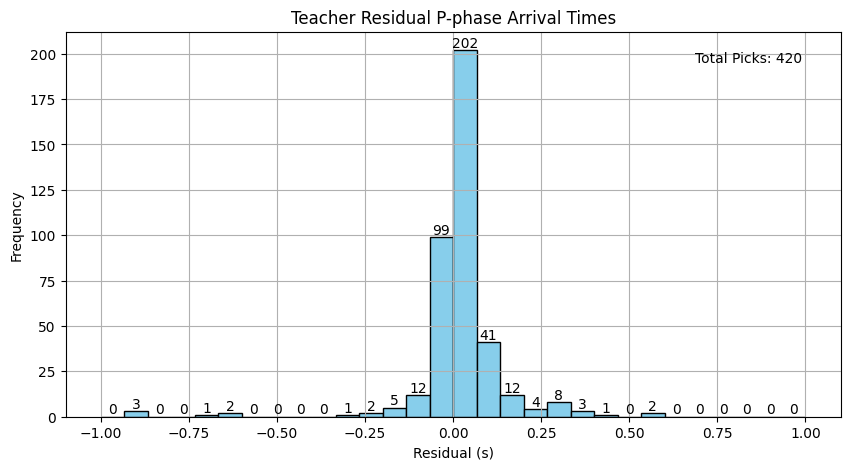

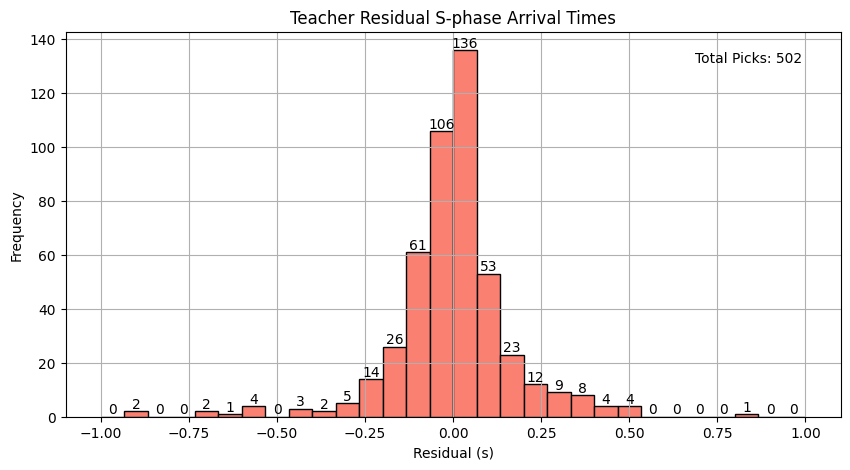


=== Student Residual Evaluation ===
Ground truth P peaks: 1316, S peaks: 1282
P residuals under 0.6s: 453
S residuals under 0.6s: 457
P residuals: mean=0.1745s, std=1.1953s, total=462
S residuals: mean=0.0228s, std=0.5619s, total=464


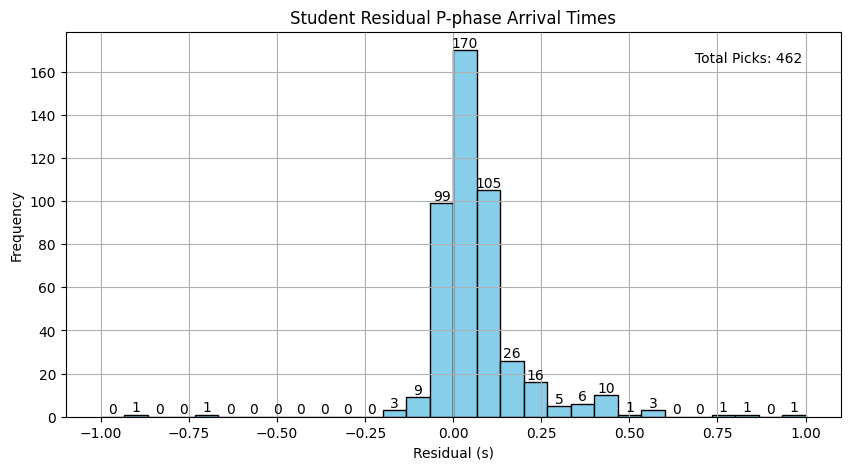

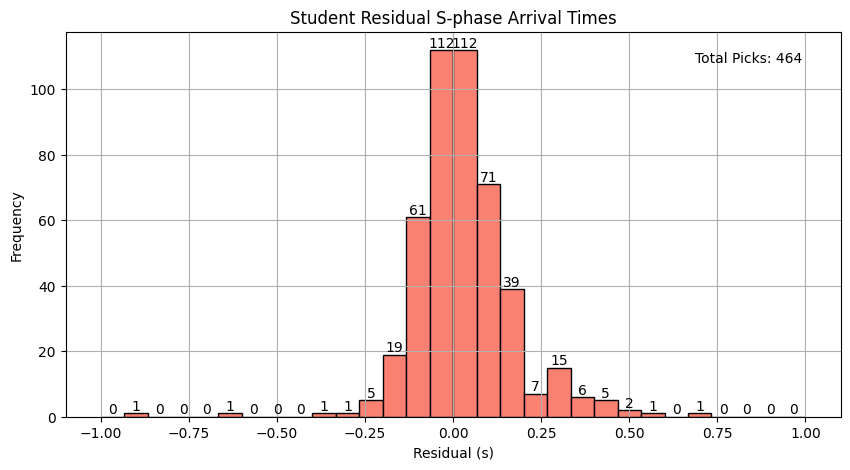


=== Teacher vs Student Summary ===
P-phase residuals under 0.6s: Teacher=392, Student=453
S-phase residuals under 0.6s: Teacher=470, Student=457
P-phase mean residual (s): Teacher=0.1501, Student=0.1745
P-phase std residual (s): Teacher=1.8150, Student=1.1953
S-phase mean residual (s): Teacher=-0.4037, Student=0.0228
S-phase std residual (s): Teacher=2.9702, Student=0.5619


In [39]:
# ------------------------------
# Residual-Based Evaluation Call
# ------------------------------

# Set evaluation parameters
height = 0.5           # Minimum peak probability
distance = 100         # Minimum peak separation (samples)
sampling_rate = 100    # Hz
tolerance = 0.6        # Seconds for residual threshold
n_samples = len(dev_generator)  # Evaluate all samples

# Evaluate Teacher Model
teacher_results = evaluate_model_residuals(
    model=teacher_model,
    data_generator=dev_generator,
    device=device,
    height=height,
    distance=distance,
    sampling_rate=sampling_rate,
    tolerance=tolerance,
    n_samples=n_samples,
    model_name="Teacher"
)

# Evaluate Student Model
student_results = evaluate_model_residuals(
    model=student_model,
    data_generator=dev_generator,
    device=device,
    height=height,
    distance=distance,
    sampling_rate=sampling_rate,
    tolerance=tolerance,
    n_samples=n_samples,
    model_name="Student"
)

# ------------------------------
# Compare Teacher vs Student
# ------------------------------

print("\n=== Teacher vs Student Summary ===")
print(f"P-phase residuals under {tolerance}s: Teacher={teacher_results['count_p_under_tol']}, Student={student_results['count_p_under_tol']}")
print(f"S-phase residuals under {tolerance}s: Teacher={teacher_results['count_s_under_tol']}, Student={student_results['count_s_under_tol']}")
print(f"P-phase mean residual (s): Teacher={teacher_results['mean_p']:.4f}, Student={student_results['mean_p']:.4f}")
print(f"P-phase std residual (s): Teacher={teacher_results['std_p']:.4f}, Student={student_results['std_p']:.4f}")
print(f"S-phase mean residual (s): Teacher={teacher_results['mean_s']:.4f}, Student={student_results['mean_s']:.4f}")
print(f"S-phase std residual (s): Teacher={teacher_results['std_s']:.4f}, Student={student_results['std_s']:.4f}")


In [40]:
import time

def evaluate_model_residuals_with_time(model, data_generator, device, 
                                       height=0.5, distance=100, sampling_rate=100,
                                       tolerance=0.6, n_samples=None, model_name="Model"):
    """
    Evaluate seismic phase picking model with residuals and measure inference time.
    
    Returns:
        dict with residuals, counts, mean/std, tolerance counts, and avg inference time
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import find_peaks
    import torch

    model.eval()
    
    if n_samples is None:
        n_samples = len(data_generator)
    
    all_residual_p_arrival_times = []
    all_residual_s_arrival_times = []
    
    groundtruth_p_peaks = 0
    groundtruth_s_peaks = 0
    count_residuals_p_under_tol = 0
    count_residuals_s_under_tol = 0
    inference_times = []

    for _ in range(n_samples):
        sample = data_generator[np.random.randint(len(data_generator))]
        X_tensor = torch.tensor(sample["X"], device=device).unsqueeze(0)

        # Ground truth peaks
        y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
        y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)
        groundtruth_p_peaks += len(y_p_peaks)
        groundtruth_s_peaks += len(y_s_peaks)
        y_p_times = y_p_peaks / sampling_rate
        y_s_times = y_s_peaks / sampling_rate

        # Model prediction with timing
        start_time = time.time()
        with torch.no_grad():
            pred = model(X_tensor)[0].cpu().numpy()
        end_time = time.time()
        inference_times.append(end_time - start_time)

        # Predicted peaks
        p_prob = pred[0]
        s_prob = pred[1]
        p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
        s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)
        p_times = p_peaks / sampling_rate
        s_times = s_peaks / sampling_rate

        # Residuals: smallest absolute difference per ground truth peak
        for y_p_time in y_p_times:
            residuals = p_times - y_p_time
            if len(residuals) > 0:
                min_res = residuals[np.argmin(np.abs(residuals))]
                all_residual_p_arrival_times.append(min_res)
                if np.abs(min_res) < tolerance:
                    count_residuals_p_under_tol += 1
        for y_s_time in y_s_times:
            residuals = s_times - y_s_time
            if len(residuals) > 0:
                min_res = residuals[np.argmin(np.abs(residuals))]
                all_residual_s_arrival_times.append(min_res)
                if np.abs(min_res) < tolerance:
                    count_residuals_s_under_tol += 1

    # Compute statistics
    all_residual_p_arrival_times = np.array(all_residual_p_arrival_times)
    all_residual_s_arrival_times = np.array(all_residual_s_arrival_times)
    mean_p = np.mean(all_residual_p_arrival_times)
    std_p = np.std(all_residual_p_arrival_times)
    mean_s = np.mean(all_residual_s_arrival_times)
    std_s = np.std(all_residual_s_arrival_times)
    avg_inference_time = np.mean(inference_times)
    std_inference_time = np.std(inference_times)

    # Print summary
    print(f"\n=== {model_name} Residual Evaluation ===")
    print(f"Ground truth P peaks: {groundtruth_p_peaks}, S peaks: {groundtruth_s_peaks}")
    print(f"P residuals under {tolerance}s: {count_residuals_p_under_tol}")
    print(f"S residuals under {tolerance}s: {count_residuals_s_under_tol}")
    print(f"P residuals: mean={mean_p:.4f}s, std={std_p:.4f}s, total={len(all_residual_p_arrival_times)}")
    print(f"S residuals: mean={mean_s:.4f}s, std={std_s:.4f}s, total={len(all_residual_s_arrival_times)}")
    print(f"Avg inference time per sample: {avg_inference_time*1000:.2f} ms ± {std_inference_time*1000:.2f} ms")

    # Plot histograms
    def plot_hist(residuals, phase_name, color, filename):
        plt.figure(figsize=(10,5))
        counts, bins, patches = plt.hist(residuals, bins=30, color=color, edgecolor='black', range=(-1, 1))
        for count, bin_, patch in zip(counts, bins, patches):
            plt.text(bin_ + (bins[1]-bins[0])/2, count, f'{int(count)}', ha='center', va='bottom')
        plt.text(0.95, 0.95, f'Total Picks: {len(residuals)}', ha='right', va='top', transform=plt.gca().transAxes)
        plt.title(f'{model_name} Residual {phase_name} Arrival Times')
        plt.xlabel('Residual (s)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(filename)
        plt.show()

    plot_hist(all_residual_p_arrival_times, 'P-phase', 'skyblue', f"{model_name}_residual_p_hist.png")
    plot_hist(all_residual_s_arrival_times, 'S-phase', 'salmon', f"{model_name}_residual_s_hist.png")

    results = {
        'model_name': model_name,
        'residuals_p': all_residual_p_arrival_times,
        'residuals_s': all_residual_s_arrival_times,
        'count_p_under_tol': count_residuals_p_under_tol,
        'count_s_under_tol': count_residuals_s_under_tol,
        'mean_p': mean_p,
        'std_p': std_p,
        'mean_s': mean_s,
        'std_s': std_s,
        'groundtruth_p_peaks': groundtruth_p_peaks,
        'groundtruth_s_peaks': groundtruth_s_peaks,
        'avg_inference_time': avg_inference_time,
        'std_inference_time': std_inference_time
    }

    return results



=== Teacher (PhaseNet) Residual Evaluation ===
Ground truth P peaks: 762, S peaks: 731
P residuals under 0.6s: 212
S residuals under 0.6s: 280
P residuals: mean=0.2622s, std=1.6260s, total=229
S residuals: mean=-0.3449s, std=2.5569s, total=298
Avg inference time per sample: 2.71 ms ± 0.89 ms


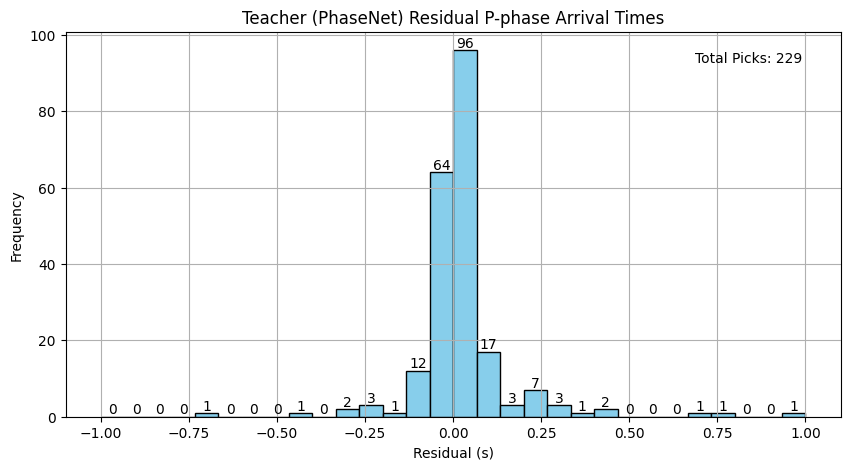

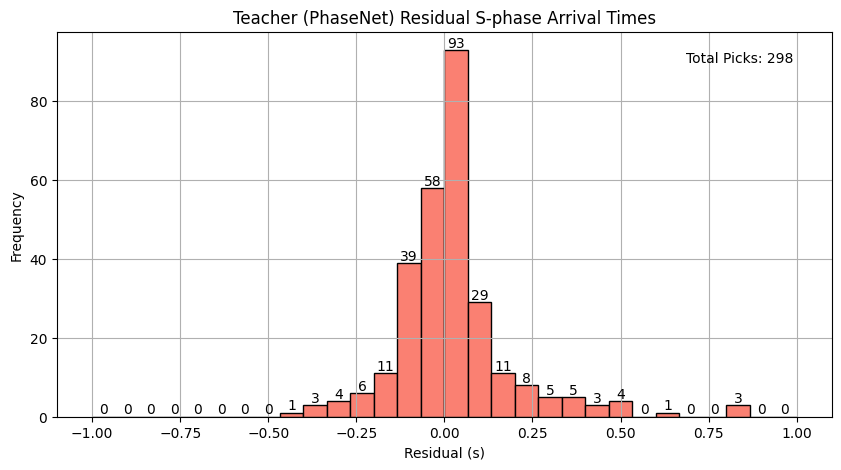


=== Student (XiaoNet) Residual Evaluation ===
Ground truth P peaks: 770, S peaks: 739
P residuals under 0.6s: 261
S residuals under 0.6s: 261
P residuals: mean=-0.0988s, std=1.8732s, total=272
S residuals: mean=0.0172s, std=0.1705s, total=265
Avg inference time per sample: 1.76 ms ± 0.57 ms


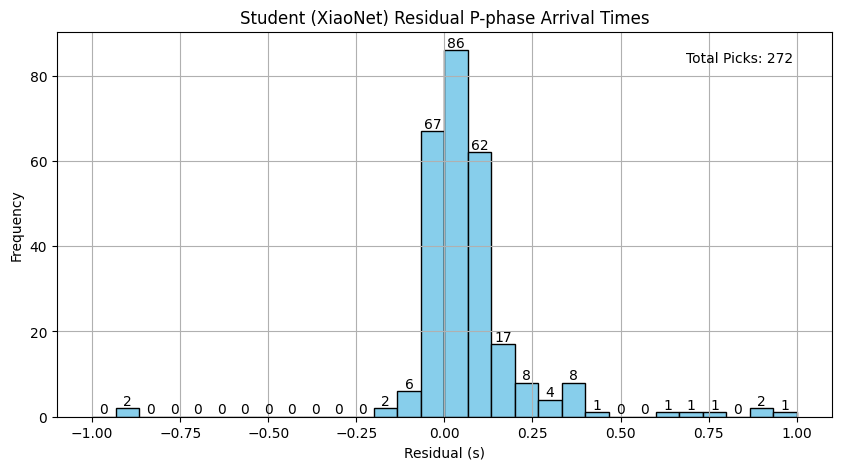

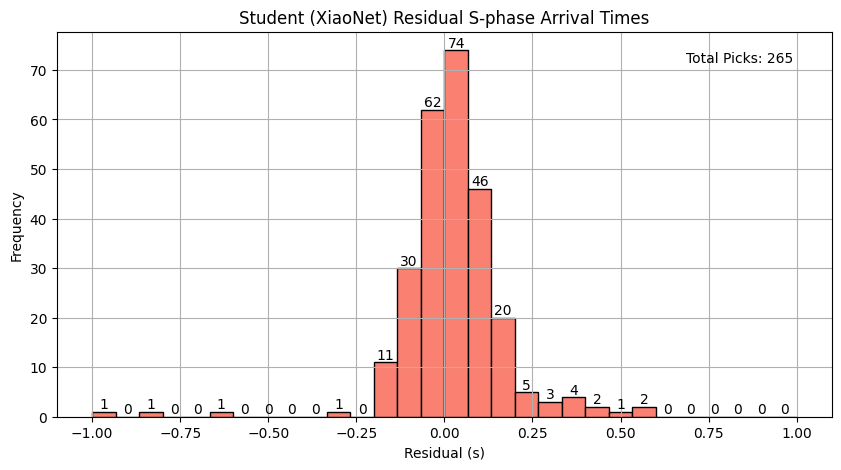


✅ Teacher vs Student Model Comparison
Metric                              | Teacher              | Student             
----------------------------------------------------------------------
Ground truth P peaks                |                  762 |                  770
Ground truth S peaks                |                  731 |                  739
P residuals under 0.6s              |                  212 |                  261
S residuals under 0.6s              |                  280 |                  261
P residuals mean ± std (s)          | 0.2622 ± 1.6260 | -0.0988 ± 1.8732
S residuals mean ± std (s)          | -0.3449 ± 2.5569 | 0.0172 ± 0.1705
Avg inference time per sample (ms)  | 2.71 ± 0.89 | 1.76 ± 0.57
Student vs Teacher Speedup          | -                    | 1.54x faster


In [41]:
# ------------------------------
# Evaluate Teacher Model
# ------------------------------
teacher_results = evaluate_model_residuals_with_time(
    model=teacher_model,
    data_generator=dev_generator,
    device=device,
    height=0.5,
    distance=100,
    sampling_rate=100,
    tolerance=0.6,
    n_samples=1000,  # or None for full dataset
    model_name="Teacher (PhaseNet)"
)

# ------------------------------
# Evaluate Student Model
# ------------------------------
student_results = evaluate_model_residuals_with_time(
    model=student_model,
    data_generator=dev_generator,
    device=device,
    height=0.5,
    distance=100,
    sampling_rate=100,
    tolerance=0.6,
    n_samples=1000,  # keep same number of samples for fair comparison
    model_name="Student (XiaoNet)"
)

# ------------------------------
# Compute Speedup
# ------------------------------
speedup = teacher_results['avg_inference_time'] / student_results['avg_inference_time']

# ------------------------------
# Print Full Comparison Table
# ------------------------------
print("\n" + "="*70)
print("✅ Teacher vs Student Model Comparison")
print("="*70)
print(f"{'Metric':35} | {'Teacher':20} | {'Student':20}")
print("-"*70)
print(f"{'Ground truth P peaks':35} | {teacher_results['groundtruth_p_peaks']:20} | {student_results['groundtruth_p_peaks']:20}")
print(f"{'Ground truth S peaks':35} | {teacher_results['groundtruth_s_peaks']:20} | {student_results['groundtruth_s_peaks']:20}")
print(f"{'P residuals under 0.6s':35} | {teacher_results['count_p_under_tol']:20} | {student_results['count_p_under_tol']:20}")
print(f"{'S residuals under 0.6s':35} | {teacher_results['count_s_under_tol']:20} | {student_results['count_s_under_tol']:20}")
print(f"{'P residuals mean ± std (s)':35} | {teacher_results['mean_p']:.4f} ± {teacher_results['std_p']:.4f} | {student_results['mean_p']:.4f} ± {student_results['std_p']:.4f}")
print(f"{'S residuals mean ± std (s)':35} | {teacher_results['mean_s']:.4f} ± {teacher_results['std_s']:.4f} | {student_results['mean_s']:.4f} ± {student_results['std_s']:.4f}")
print(f"{'Avg inference time per sample (ms)':35} | {teacher_results['avg_inference_time']*1000:.2f} ± {teacher_results['std_inference_time']*1000:.2f} | {student_results['avg_inference_time']*1000:.2f} ± {student_results['std_inference_time']*1000:.2f}")
print(f"{'Student vs Teacher Speedup':35} | {'-':20} | {speedup:.2f}x faster")
print("="*70)


In [45]:
#!/usr/bin/env python
# coding: utf-8

import os
import torch
import matplotlib.pyplot as plt
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
import numpy as np
from scipy.signal import find_peaks

# Load model function
def load_model(model_class, model_filename, device, **kwargs):
    """
    Load a model from a file.
    Args:
        model_class: Model class (e.g., sbm.PhaseNet or your custom XiaoNet)
        model_filename: Filename of the saved model weights
        device: Device to load the model onto
        **kwargs: Additional arguments for model initialization
    Returns:
        Model with loaded weights
    """
    model = model_class(**kwargs)
    model.load_state_dict(torch.load(model_filename, map_location=device))
    model.to(device)
    model.eval()
    return model

# Load your student model (adjust the class and parameters as needed)
# If you have a custom student model:
# from your_module import XiaoNet
# student_model = load_model(XiaoNet, "best_student_distilled.pth", device)

# Create output folders
output_folder = "comparison_examples"
os.makedirs(output_folder, exist_ok=True)

# Parameters for peak detection
sampling_rate = 100  # Hz
height = 0.5
distance = 100

print(f"\nGenerating {100} comparison examples...")
print(f"Parameters: height={height}, distance={distance}, sampling_rate={sampling_rate}Hz")

# Generate comparison plots
for i in range(1, 101):
    # Get a sample
    sample = dev_generator[np.random.randint(len(dev_generator))]
    
    # Find ground truth peaks
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)
    y_p_times = y_p_peaks / sampling_rate
    y_s_times = y_s_peaks / sampling_rate
    
    # Get teacher predictions
    with torch.no_grad():
        teacher_pred = teacher_model(torch.tensor(sample["X"], device=device).unsqueeze(0))
        teacher_pred = teacher_pred[0].cpu().numpy()
    
    # Get student predictions
    with torch.no_grad():
        student_pred = student_model(torch.tensor(sample["X"], device=device).unsqueeze(0))
        student_pred = student_pred[0].cpu().numpy()
    
    # Find peaks in teacher predictions
    teacher_p_prob = teacher_pred[0]
    teacher_s_prob = teacher_pred[1]
    teacher_p_peaks, _ = find_peaks(teacher_p_prob, height=height, distance=distance)
    teacher_s_peaks, _ = find_peaks(teacher_s_prob, height=height, distance=distance)
    teacher_p_times = teacher_p_peaks / sampling_rate
    teacher_s_times = teacher_s_peaks / sampling_rate
    
    # Find peaks in student predictions
    student_p_prob = student_pred[0]
    student_s_prob = student_pred[1]
    student_p_peaks, _ = find_peaks(student_p_prob, height=height, distance=distance)
    student_s_peaks, _ = find_peaks(student_s_prob, height=height, distance=distance)
    student_p_times = student_p_peaks / sampling_rate
    student_s_times = student_s_peaks / sampling_rate
    
    # Create comparison plot
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(5, 2, hspace=0.3, wspace=0.3, height_ratios=[3, 1, 1, 1, 1])
    
    # Row 1: Input waveforms (shared)
    ax_waveform = fig.add_subplot(gs[0, :])
    ax_waveform.plot(sample["X"].T, linewidth=0.8)
    ax_waveform.set_title('Input Seismic Waveforms (3 channels)', fontsize=14, fontweight='bold')
    ax_waveform.set_ylabel('Amplitude')
    ax_waveform.grid(True, alpha=0.3)
    ax_waveform.legend(['Channel 1', 'Channel 2', 'Channel 3'], loc='upper right')
    
    # Row 2: Ground Truth
    ax_gt_left = fig.add_subplot(gs[1, 0])
    ax_gt_right = fig.add_subplot(gs[1, 1])
    
    for ax in [ax_gt_left, ax_gt_right]:
        ax.plot(sample["y"][0], label='P-phase GT', color='red', alpha=0.6)
        ax.plot(sample["y"][1], label='S-phase GT', color='blue', alpha=0.6)
        ax.plot(y_p_peaks, sample["y"][0, y_p_peaks], 'o', 
               label=f'P peaks ({len(y_p_peaks)})', color='darkred', markersize=8)
        ax.plot(y_s_peaks, sample["y"][1, y_s_peaks], 'o', 
               label=f'S peaks ({len(y_s_peaks)})', color='darkblue', markersize=8)
        ax.set_ylabel('Probability')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    ax_gt_left.set_title('Ground Truth Labels', fontsize=12, fontweight='bold')
    ax_gt_right.set_title('Ground Truth Labels', fontsize=12, fontweight='bold')
    
    # Row 3: Teacher Predictions
    ax_teacher = fig.add_subplot(gs[2, 0])
    ax_teacher.plot(teacher_p_prob, label='P-phase Prob', color='red', alpha=0.6)
    ax_teacher.plot(teacher_p_peaks, teacher_p_prob[teacher_p_peaks], 'x', 
                   label=f'P peaks ({len(teacher_p_peaks)})', color='darkred', markersize=10, markeredgewidth=2)
    ax_teacher.plot(teacher_s_prob, label='S-phase Prob', color='blue', alpha=0.6)
    ax_teacher.plot(teacher_s_peaks, teacher_s_prob[teacher_s_peaks], 'x', 
                   label=f'S peaks ({len(teacher_s_peaks)})', color='darkblue', markersize=10, markeredgewidth=2)
    ax_teacher.set_title('Teacher Model Predictions (PhaseNet)', fontsize=12, fontweight='bold', color='green')
    ax_teacher.set_ylabel('Probability')
    ax_teacher.legend(loc='upper right', fontsize=8)
    ax_teacher.grid(True, alpha=0.3)
    
    # Row 3: Student Predictions
    ax_student = fig.add_subplot(gs[2, 1])
    ax_student.plot(student_p_prob, label='P-phase Prob', color='red', alpha=0.6)
    ax_student.plot(student_p_peaks, student_p_prob[student_p_peaks], 'x', 
                   label=f'P peaks ({len(student_p_peaks)})', color='darkred', markersize=10, markeredgewidth=2)
    ax_student.plot(student_s_prob, label='S-phase Prob', color='blue', alpha=0.6)
    ax_student.plot(student_s_peaks, student_s_prob[student_s_peaks], 'x', 
                   label=f'S peaks ({len(student_s_peaks)})', color='darkblue', markersize=10, markeredgewidth=2)
    ax_student.set_title('Student Model Predictions', fontsize=12, fontweight='bold', color='purple')
    ax_student.set_ylabel('Probability')
    ax_student.legend(loc='upper right', fontsize=8)
    ax_student.grid(True, alpha=0.3)
    
    # Row 4: Probability comparison overlay - Teacher
    ax_overlay_teacher = fig.add_subplot(gs[3, 0])
    ax_overlay_teacher.plot(sample["y"][0], label='GT P-phase', color='red', 
                           linestyle='--', alpha=0.5, linewidth=2)
    ax_overlay_teacher.plot(teacher_p_prob, label='Teacher P-phase', color='red', alpha=0.8)
    ax_overlay_teacher.plot(sample["y"][1], label='GT S-phase', color='blue', 
                           linestyle='--', alpha=0.5, linewidth=2)
    ax_overlay_teacher.plot(teacher_s_prob, label='Teacher S-phase', color='blue', alpha=0.8)
    ax_overlay_teacher.set_title('Teacher vs Ground Truth Overlay', fontsize=11)
    ax_overlay_teacher.set_ylabel('Probability')
    ax_overlay_teacher.legend(loc='upper right', fontsize=7)
    ax_overlay_teacher.grid(True, alpha=0.3)
    
    # Row 4: Probability comparison overlay - Student
    ax_overlay_student = fig.add_subplot(gs[3, 1])
    ax_overlay_student.plot(sample["y"][0], label='GT P-phase', color='red', 
                           linestyle='--', alpha=0.5, linewidth=2)
    ax_overlay_student.plot(student_p_prob, label='Student P-phase', color='red', alpha=0.8)
    ax_overlay_student.plot(sample["y"][1], label='GT S-phase', color='blue', 
                           linestyle='--', alpha=0.5, linewidth=2)
    ax_overlay_student.plot(student_s_prob, label='Student S-phase', color='blue', alpha=0.8)
    ax_overlay_student.set_title('Student vs Ground Truth Overlay', fontsize=11)
    ax_overlay_student.set_ylabel('Probability')
    ax_overlay_student.legend(loc='upper right', fontsize=7)
    ax_overlay_student.grid(True, alpha=0.3)
    
    # Row 5: Direct Teacher vs Student comparison
    ax_compare_p = fig.add_subplot(gs[4, 0])
    ax_compare_p.plot(teacher_p_prob, label='Teacher P-phase', color='green', alpha=0.7, linewidth=2)
    ax_compare_p.plot(student_p_prob, label='Student P-phase', color='purple', 
                     alpha=0.7, linewidth=2, linestyle='--')
    ax_compare_p.plot(sample["y"][0], label='Ground Truth', color='black', 
                     alpha=0.4, linewidth=1, linestyle=':')
    ax_compare_p.set_title('P-phase: Teacher vs Student', fontsize=11)
    ax_compare_p.set_xlabel('Sample Index')
    ax_compare_p.set_ylabel('Probability')
    ax_compare_p.legend(loc='upper right', fontsize=8)
    ax_compare_p.grid(True, alpha=0.3)
    
    ax_compare_s = fig.add_subplot(gs[4, 1])
    ax_compare_s.plot(teacher_s_prob, label='Teacher S-phase', color='green', alpha=0.7, linewidth=2)
    ax_compare_s.plot(student_s_prob, label='Student S-phase', color='purple', 
                     alpha=0.7, linewidth=2, linestyle='--')
    ax_compare_s.plot(sample["y"][1], label='Ground Truth', color='black', 
                     alpha=0.4, linewidth=1, linestyle=':')
    ax_compare_s.set_title('S-phase: Teacher vs Student', fontsize=11)
    ax_compare_s.set_xlabel('Sample Index')
    ax_compare_s.set_ylabel('Probability')
    ax_compare_s.legend(loc='upper right', fontsize=8)
    ax_compare_s.grid(True, alpha=0.3)
    
    # Overall title
    fig.suptitle(f'Example {i}: Teacher vs Student Model Comparison', 
                fontsize=16, fontweight='bold', y=0.995)
    
    # Save figure
    plot_filename = os.path.join(output_folder, f"Comparison_{i:03d}.png")
    plt.savefig(plot_filename, dpi=200, bbox_inches='tight')
    plt.close(fig)
    
    # Calculate residuals for both models
    teacher_residuals_p = []
    teacher_residuals_s = []
    student_residuals_p = []
    student_residuals_s = []
    
    for y_p_time in y_p_times:
        if len(teacher_p_times) > 0:
            residuals = teacher_p_times - y_p_time
            teacher_residuals_p.append(residuals[np.argmin(np.abs(residuals))])
        if len(student_p_times) > 0:
            residuals = student_p_times - y_p_time
            student_residuals_p.append(residuals[np.argmin(np.abs(residuals))])
    
    for y_s_time in y_s_times:
        if len(teacher_s_times) > 0:
            residuals = teacher_s_times - y_s_time
            teacher_residuals_s.append(residuals[np.argmin(np.abs(residuals))])
        if len(student_s_times) > 0:
            residuals = student_s_times - y_s_time
            student_residuals_s.append(residuals[np.argmin(np.abs(residuals))])
    
    # Save results to text file
    results_filename = os.path.join(output_folder, f"Comparison_{i:03d}_Results.txt")
    with open(results_filename, "w") as f:
        f.write(f"Example {i} - Comparison Results\n")
        f.write("="*60 + "\n\n")
        
        f.write("GROUND TRUTH:\n")
        f.write(f"  P arrival times: {y_p_times}\n")
        f.write(f"  S arrival times: {y_s_times}\n\n")
        
        f.write("TEACHER MODEL (PhaseNet):\n")
        f.write(f"  Predicted P times: {teacher_p_times}\n")
        f.write(f"  Predicted S times: {teacher_s_times}\n")
        f.write(f"  P residuals: {teacher_residuals_p}\n")
        f.write(f"  S residuals: {teacher_residuals_s}\n\n")
        
        f.write("STUDENT MODEL:\n")
        f.write(f"  Predicted P times: {student_p_times}\n")
        f.write(f"  Predicted S times: {student_s_times}\n")
        f.write(f"  P residuals: {student_residuals_p}\n")
        f.write(f"  S residuals: {student_residuals_s}\n\n")
        
        f.write("PERFORMANCE COMPARISON:\n")
        if teacher_residuals_p and student_residuals_p:
            f.write(f"  Teacher P MAE: {np.mean(np.abs(teacher_residuals_p)):.4f}s\n")
            f.write(f"  Student P MAE: {np.mean(np.abs(student_residuals_p)):.4f}s\n")
        if teacher_residuals_s and student_residuals_s:
            f.write(f"  Teacher S MAE: {np.mean(np.abs(teacher_residuals_s)):.4f}s\n")
            f.write(f"  Student S MAE: {np.mean(np.abs(student_residuals_s)):.4f}s\n")
    
    if (i % 10 == 0):
        print(f"  Generated {i}/100 comparison examples...")

print(f"\n✓ All comparison examples saved to '{output_folder}/'")
print(f"✓ Generated {100} comparison plots")

# Save parameters
params_filename = os.path.join(output_folder, "Comparison_Parameters.txt")
with open(params_filename, "w") as f:
    f.write("COMPARISON PARAMETERS\n")
    f.write("="*60 + "\n")
    f.write(f"Sampling Rate: {sampling_rate} Hz\n")
    f.write(f"Height Parameter: {height}\n")
    f.write(f"Distance Parameter: {distance}\n")

print(f"✓ Parameters saved to '{params_filename}'")


Generating 100 comparison examples...
Parameters: height=0.5, distance=100, sampling_rate=100Hz
  Generated 10/100 comparison examples...
  Generated 20/100 comparison examples...
  Generated 30/100 comparison examples...
  Generated 40/100 comparison examples...
  Generated 50/100 comparison examples...
  Generated 60/100 comparison examples...
  Generated 70/100 comparison examples...
  Generated 80/100 comparison examples...
  Generated 90/100 comparison examples...
  Generated 100/100 comparison examples...

✓ All comparison examples saved to 'comparison_examples/'
✓ Generated 100 comparison plots
✓ Parameters saved to 'comparison_examples/Comparison_Parameters.txt'
